In [1]:
import os, sys, re, datetime, shutil, copy, subprocess
import numpy as np
import astropy.units as u
import astropy.constants as const
from astropy.io import fits
from astropy.table import Table
from collections import OrderedDict
sys.path.insert(1, os.path.join(os.path.dirname(os.getcwd()), 'utils'))
radex_calc_path = os.path.join(os.path.dirname(os.getcwd()), 'tmp', 'calc_radex_disky') # 'calc_radex'
LTE_calc_path = os.path.join(os.path.dirname(os.getcwd()), 'tmp', 'calc_LTE')

In [2]:
# User defined global parameters

%run calc_NonLTE_RADEX_plot_R_CI10CO21_correction_matrix.ipynb

if __name__ == '__main__' and '__file__' not in globals():

    select_X_CICO = 0.2

    out_fig_name = 'Plot_RADEX_alpha_CI10_varied_CO_abundance_selected_RNCINCO_' + \
                   ('%.1f'%(select_X_CICO)).replace('.','p')


In [3]:
# Define alphaCI function

%run calc_LTE_alpha_CO_CI_new.ipynb

func_T_only = func_alpha_CI

def func_T_NLCorr_alphaCI10(T_kin, CI_abundance, N_CO_d_V = None, n_H2 = None):
    """Compute DZLIU T-NLCorr alpha conversion factor.
    
    The T-NLCorr approximation is combining the T-only approximation with a
    (n_H2) scaling. 
    
    The T-only approximation optimized parameters
    are fitted by the code "calc_LTE_alpha_CO_CI_new.ipynb".
    
    """
    # Load T-only approximation optimized parameters. 
    # They are derived in "calc_LTE_alpha_CO_CI_new.ipynb"
    global CI10_T_only_popt
    popt = CI10_T_only_popt
    # 
    # Apply T-only approximation with CI abundance.
    # `func_alpha_CI` is defined in "calc_LTE_alpha_CO_CI_new.ipynb"
    val = func_alpha_CI(T_kin, *popt) * (2e-5) / CI_abundance
    # 
    # Below are T-prime-NLCorr approximation parts fitted below in this code.
    # See the printed "fitted NLCorr hybrid formula ..." content below.
    if n_H2 is not None:
        val *= 0.998011 / ( 1.0 - np.exp( \
               - ((np.log10(n_H2) - 1.27141 * np.log10(1.19667/T_kin)) / 4.31057)**(6.74671) ) )
    # 
    return val


list_of_alphaCO10_for_N_repISM [2.574, 1.471, 0.692, 0.654, 0.753, 0.573, 0.525]
list_of_Sigma_H2_for_N_repISM [102.941, 220.588, 294.118, 588.235, 640.414, 687.798, 1102.941]
list_of_Sigma_mol_for_N_repISM [140.000, 300.000, 400.000, 800.000, 870.964, 935.406, 1500.000]
list_of_N_H2_for_N_repISM [6.424e+21, 1.376e+22, 1.835e+22, 3.671e+22, 3.996e+22, 4.292e+22, 6.882e+22]
list_of_N_CO_for_N_repISM [6.424e+17, 1.376e+18, 1.835e+18, 3.671e+18, 3.996e+18, 4.292e+18, 6.882e+18]
list_of_N_CI_for_N_repISM [1.285e+17, 2.753e+17, 3.671e+17, 7.341e+17, 7.992e+17, 8.584e+17, 1.376e+18]
list_of_N_CO_d_V_for_N_repISM [2.141e+17, 1.376e+17, 7.341e+16, 7.341e+16, 9.990e+16, 6.131e+16, 7.647e+16]
Loading 'out_LTE_alphaCO_alphaCI_new_QE_term_popt.json'
CO10_C_coeff = 0.019154525467252038 # s solMass / (K km pc2)
CO10_QE_popt = [1.1841972425580587, 1.0501500500798997, 0.13536555224402363, 3.0465464845741184]
CO21_C_coeff = 0.004791830144641124 # s solMass / (K km pc2)
CO21_QE_popt = [0.320706452865248

In [4]:
# Define function to prepare the data arrays for the three figures

def read_data_tables_for_three_figures():
    global list_of_N_CO
    global list_of_n_H2
    global list_of_T_kin
    global list_of_CO_abundance_for_T_kin
    global select_X_CICO
    global select_d_V
    xpos_array = np.full([len(list_of_N_CO), len(list_of_n_H2)], fill_value=np.nan)
    ypos_array = np.full([len(list_of_N_CO), len(list_of_n_H2)], fill_value=np.nan)
    fig1_array = np.full([len(list_of_T_kin), len(list_of_N_CO), len(list_of_n_H2)], fill_value=np.nan)
    fig2_array = np.full([len(list_of_T_kin), len(list_of_N_CO), len(list_of_n_H2)], fill_value=np.nan)
    fig3_array = np.full([len(list_of_T_kin), len(list_of_N_CO), len(list_of_n_H2)], fill_value=np.nan)
    fig4_array = np.full([len(list_of_T_kin), len(list_of_N_CO), len(list_of_n_H2)], fill_value=np.nan)
    for iax, T_kin in enumerate(list_of_T_kin):
        #d_V = list_of_d_V_for_T_kin[iax]
        CO_abundance = list_of_CO_abundance_for_T_kin[iax]
        data_table = get_data_table_by_X_CICO_d_V(select_X_CICO, 
                                                  select_d_V, 
                                                  radex_calc_path = radex_calc_path, 
                                                  check_T_kin_in_table = T_kin, 
                                                 )
        for iy, N_CO in enumerate(list_of_N_CO):
            for ix, n_H2 in enumerate(list_of_n_H2):
                if iax == 0:
                    xpos_array[iy, ix] = np.log10(n_H2)
                    ypos_array[iy, ix] = np.log10(N_CO) + np.log10(select_X_CICO) - np.log10(select_d_V)
                irow = np.argwhere(np.logical_and.reduce((
                    np.isclose(np.log10(data_table['N_CO']), np.log10(N_CO)), 
                    np.isclose(np.log10(data_table['n_H2']), np.log10(n_H2)), 
                    np.isclose(data_table['T_kin'], T_kin), 
                ))).ravel()
                if len(irow) > 0:
                    irow = irow[0]
                else:
                    raise Exception('Data not found in table: N_CO {} n_H2 {} T_kin {} table {!r}'.format(
                        np.log10(N_CO), np.log10(n_H2), T_kin, 
                    ))
                # 
                alpha_CI10_LTE = func_T_NLCorr_alphaCI10(T_kin, CO_abundance * select_X_CICO)
                alpha_CI10_NLCorr = func_T_NLCorr_alphaCI10(T_kin, CO_abundance * select_X_CICO, 
                                                            N_CO_d_V = N_CO / select_d_V, 
                                                            n_H2 = n_H2)
                #alpha_CI10_LTE2 = N_CO / CO_abundance * 1.6027265100590378e-20 / \
                #                  data_table['Flux_Kkms_CI10_LTE'][irow]
                alpha_CI10_NonLTE = N_CO / CO_abundance * 1.6027265100590378e-20 / \
                                    data_table['Flux_Kkms_CI10_NonLTE'][irow]
                fig1_array[iax, iy, ix] = alpha_CI10_LTE
                fig2_array[iax, iy, ix] = alpha_CI10_NonLTE
                fig3_array[iax, iy, ix] = alpha_CI10_NonLTE/alpha_CI10_LTE
                fig4_array[iax, iy, ix] = alpha_CI10_NonLTE/alpha_CI10_NLCorr
    # 
    return xpos_array, ypos_array, fig1_array, fig2_array, fig3_array, fig4_array

# Read the data tables into the global variables

if __name__ == '__main__' and '__file__' not in globals():
    
    xpos_array, ypos_array, fig1_array, fig2_array, fig3_array, fig4_array = \
        read_data_tables_for_three_figures()


lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_10.0kms.csv"
lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_10.0kms.csv"
lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_10.0kms.csv"
lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_10.0kms.csv"
lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_Liu_CO_CI/Excitation_Analysis/CICOExcitation/tmp/calc_radex_disky/out_table_RADEX_R_CI10CO21_sim_XCICO_0.2_dv_10.0kms.csv"
lookup_key XCICO_0.2_dv_10.0kms
Reading "/Users/dzliu/Work/2020_L

axRight y[0,0] 15.301029995663981 y[-1,0] 17.30102999566398
axRight ylim 1.6014179100000001 160.141791
axRight ylim 0.2045046812778552 2.204504681277855 in log
axRight ylim [0.07950468 2.32950468]
axRight ylim [  1.20089402 213.55251048] in linear
axRight set_ylim [  1.20089402 213.55251048]
axRight get_ylim (1.200894017430284, 213.55251048351965)
Output to 'Plot_RADEX_alpha_CI10_varied_CO_abundance_selected_RNCINCO_0p2_LTE.pdf'


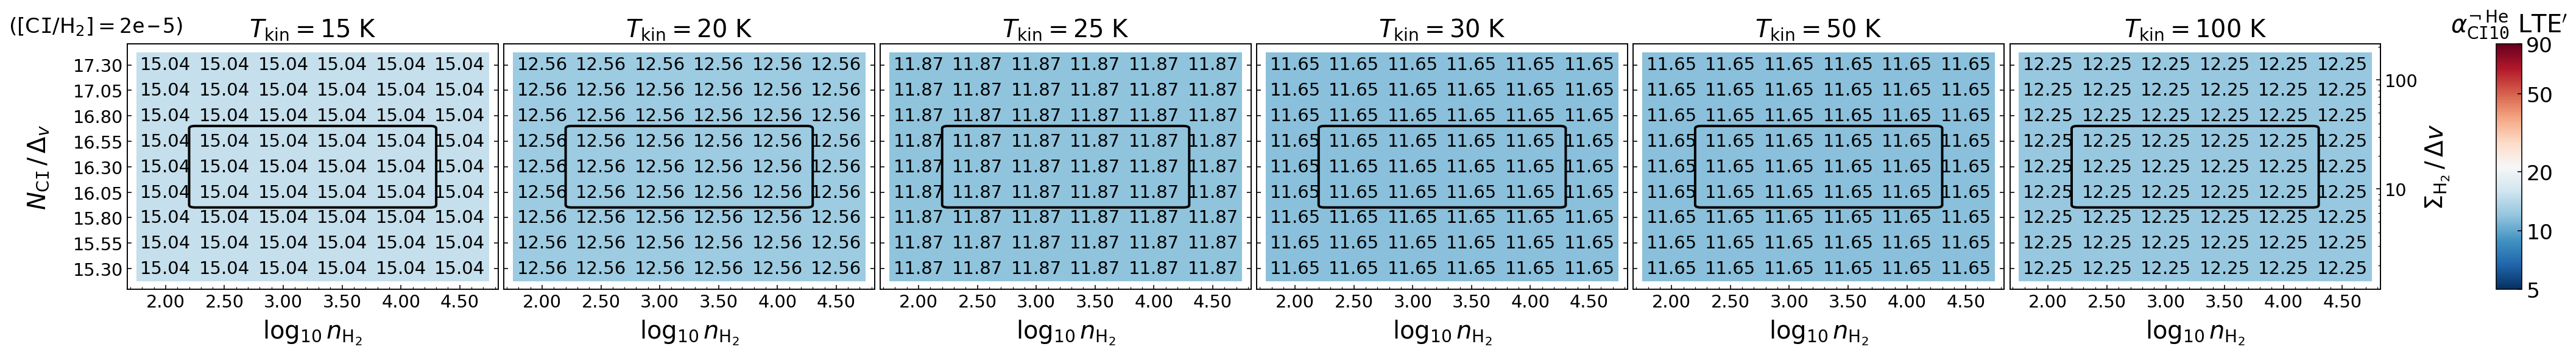

In [5]:
# Make fig1

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

if __name__ == '__main__' and '__file__' not in globals():

    panel_titles = [r'$T_{\mathrm{kin}} = ' + '%.0f'%(T_kin) + '$ K' for T_kin in list_of_T_kin]

    colorbar_title = r'$\alpha_{\mathrm{C}\tt{I}10}^{\neg\,\mathrm{He}}$' + ' ' + \
                     r'$\mathrm{LTE}^{\prime}$'

    colorbar_ticks = [5., 10., 20., 50., 90.]

    CI_abundance = (list_of_CO_abundance_for_T_kin[0] * select_X_CICO)
    CI_abundance_str = '{:g}e{:g}'.format(CI_abundance/10**np.floor(np.log10(CI_abundance)), 
                                          np.floor(np.log10(CI_abundance)))
    topleft_text = r'($[{\mathrm{C}\tt{I}}/{\mathrm{H_2}}]={\tt{%s}})$'%(CI_abundance_str)
    
    ylabel = r'$N_{\mathrm{C}\tt{I}} \, / \, \Delta_{v}$'
    
    rightmost_yfunc = lambda t_: (10**t_ / (CI_abundance) * 1.60141791e-20)
    
    highlight_boxes = [(2.50, 16.75+np.log10(select_X_CICO))] * len(list_of_CO_abundance_for_T_kin)

    fig1 = plot_one_figure(
        xpos_array, 
        ypos_array, 
        fig1_array, 
        vmin = 5.0, 
        vmax = 90.0, 
        aspect = aspect, 
        panel_titles = panel_titles, 
        colorbar_title = colorbar_title, 
        colorbar_ticks = colorbar_ticks, 
        topleft_text = topleft_text, 
        ylabel = ylabel, 
        rightmost_yfunc = rightmost_yfunc, 
        highlight_boxes = highlight_boxes, 
        #colormap = 'Reds_r', 
        save_figure_file = out_fig_name + '_LTE.pdf', 
    )

axRight y[0,0] 15.301029995663981 y[-1,0] 17.30102999566398
axRight ylim 1.6014179100000001 160.141791
axRight ylim 0.2045046812778552 2.204504681277855 in log
axRight ylim [0.07950468 2.32950468]
axRight ylim [  1.20089402 213.55251048] in linear
axRight set_ylim [  1.20089402 213.55251048]
axRight get_ylim (1.200894017430284, 213.55251048351965)
Output to 'Plot_RADEX_alpha_CI10_varied_CO_abundance_selected_RNCINCO_0p2_NonLTE.pdf'


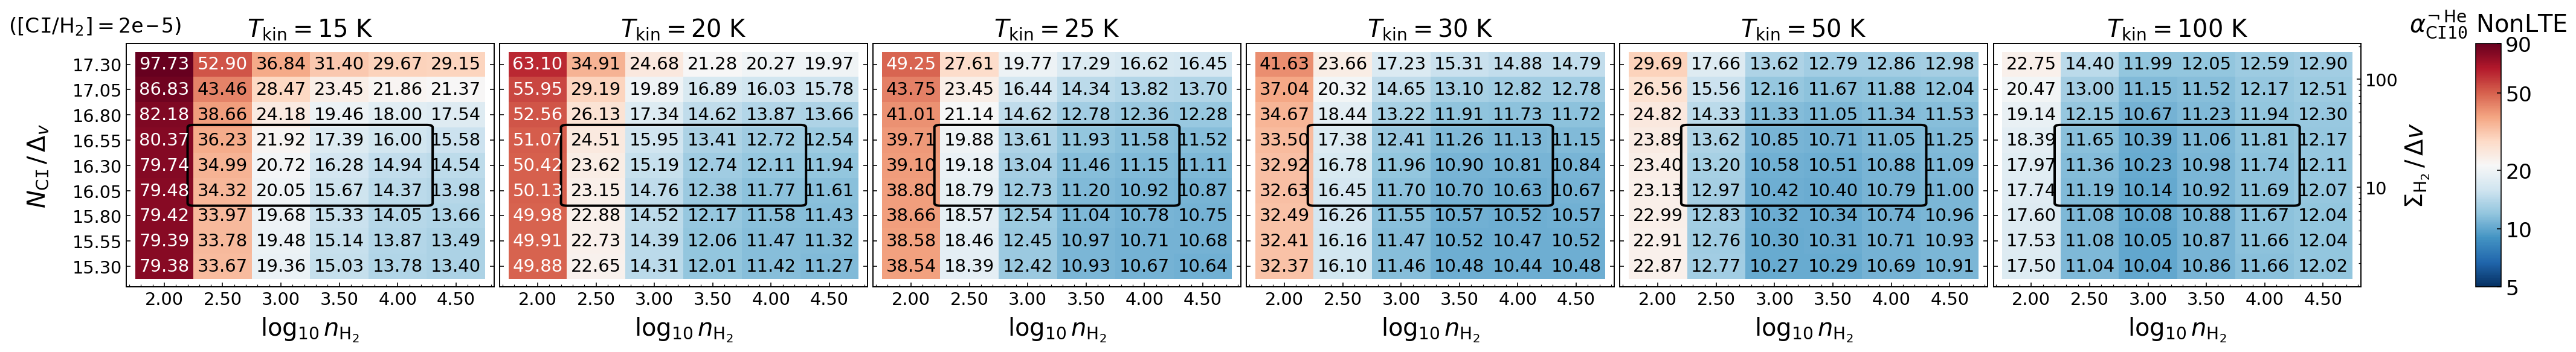

In [6]:
# Make fig2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

if __name__ == '__main__' and '__file__' not in globals():

    colorbar_title = r'$\alpha_{\mathrm{C}\tt{I}10}^{\neg\,\mathrm{He}}$' + ' ' + \
                     r'$\mathrm{NonLTE}$'
    
    #colorbar_ticks = [5., 10., 20., 50., 90.]

    fig2 = plot_one_figure(
        xpos_array, 
        ypos_array, 
        fig2_array, 
        vmin = 5.0, 
        vmax = 90.0, 
        aspect = aspect, 
        panel_titles = panel_titles, 
        colorbar_title = colorbar_title, 
        colorbar_ticks = colorbar_ticks, 
        topleft_text = topleft_text, 
        ylabel = ylabel, 
        rightmost_yfunc = rightmost_yfunc, 
        highlight_boxes = highlight_boxes, 
        #colormap = 'Blues_r', 
        save_figure_file = out_fig_name + '_NonLTE.pdf', 
    )

axRight y[0,0] 15.301029995663981 y[-1,0] 17.30102999566398
axRight ylim 1.6014179100000001 160.141791
axRight ylim 0.2045046812778552 2.204504681277855 in log
axRight ylim [0.07950468 2.32950468]
axRight ylim [  1.20089402 213.55251048] in linear
axRight set_ylim [  1.20089402 213.55251048]
axRight get_ylim (1.200894017430284, 213.55251048351965)
Output to 'Plot_RADEX_alpha_CI10_varied_CO_abundance_selected_RNCINCO_0p2_R_NLCorr.pdf'


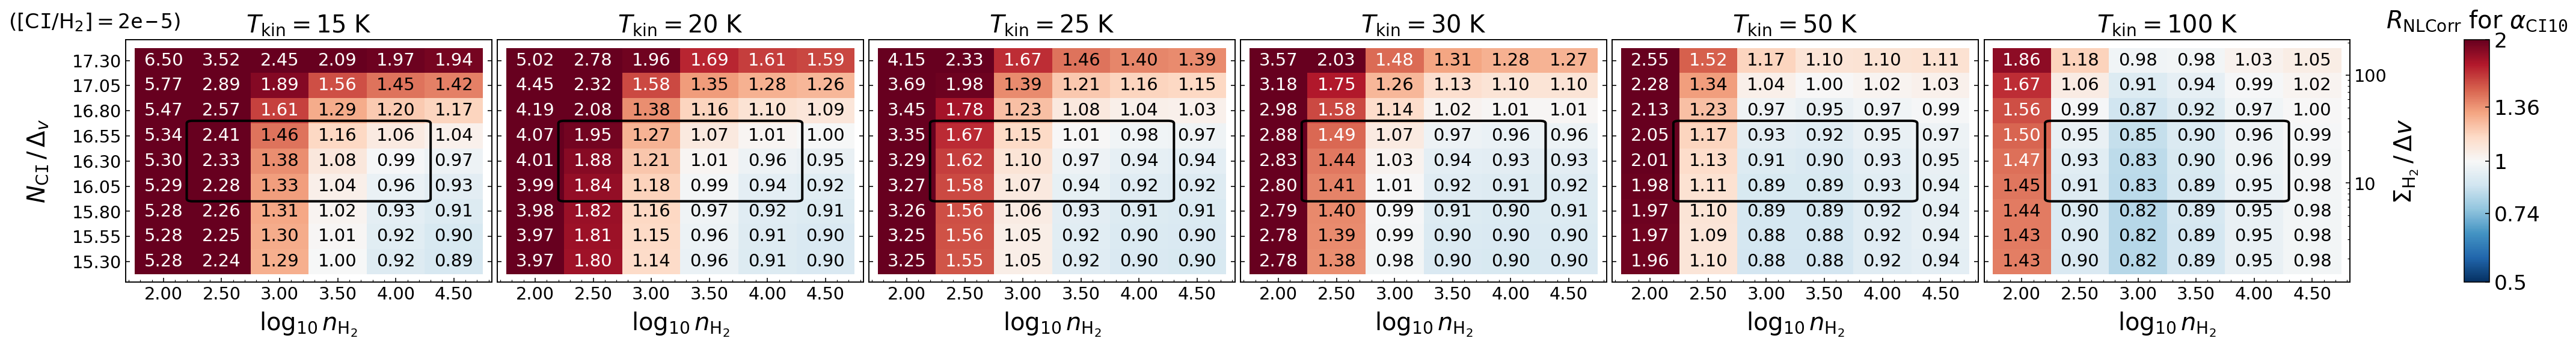

In [7]:
# Make fig3

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

if __name__ == '__main__' and '__file__' not in globals():

    colorbar_title = r'$R_{\mathrm{NLCorr}}$ for $\alpha_{\mathrm{C}\tt{I}10}$'
    
    colorbar_ticks = [0.5, 0.74, 1.0, 1.36, 2.0]

    fig3 = plot_one_figure(
        xpos_array, 
        ypos_array, 
        fig3_array, 
        vmin = 0.5, 
        vmax = 2.0, 
        aspect = aspect, 
        panel_titles = panel_titles, 
        colorbar_title = colorbar_title, 
        colorbar_ticks = colorbar_ticks, 
        topleft_text = topleft_text, 
        ylabel = ylabel, 
        rightmost_yfunc = rightmost_yfunc, 
        highlight_boxes = highlight_boxes, 
        save_figure_file = out_fig_name + '_R_NLCorr.pdf', 
    )

Output to 'out_NLCorr_matrix_alphaCI10.fits'


/Users/dzliu/Software/CONDA/miniconda3/envs/condapy37/lib/python3.7/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in log10


fitted NLCorr hybrid formula: 0.998011 / ( 1.0 - np.exp( - ((np.log10(n_H2) - 1.27141 * np.log10(1.19663/T_kin)) / 4.31058)**(6.74674) ) )
fitted NLCorr hybrid popt: [0.9980107355717894, 4.310584925560028, 6.746742673492576, 1.271412509628447, 1.1966304389698426]
Output to 'Plot_RADEX_alpha_CI10_varied_CO_abundance_selected_RNCINCO_0p2_R_NLCorr_curve_fit.pdf'


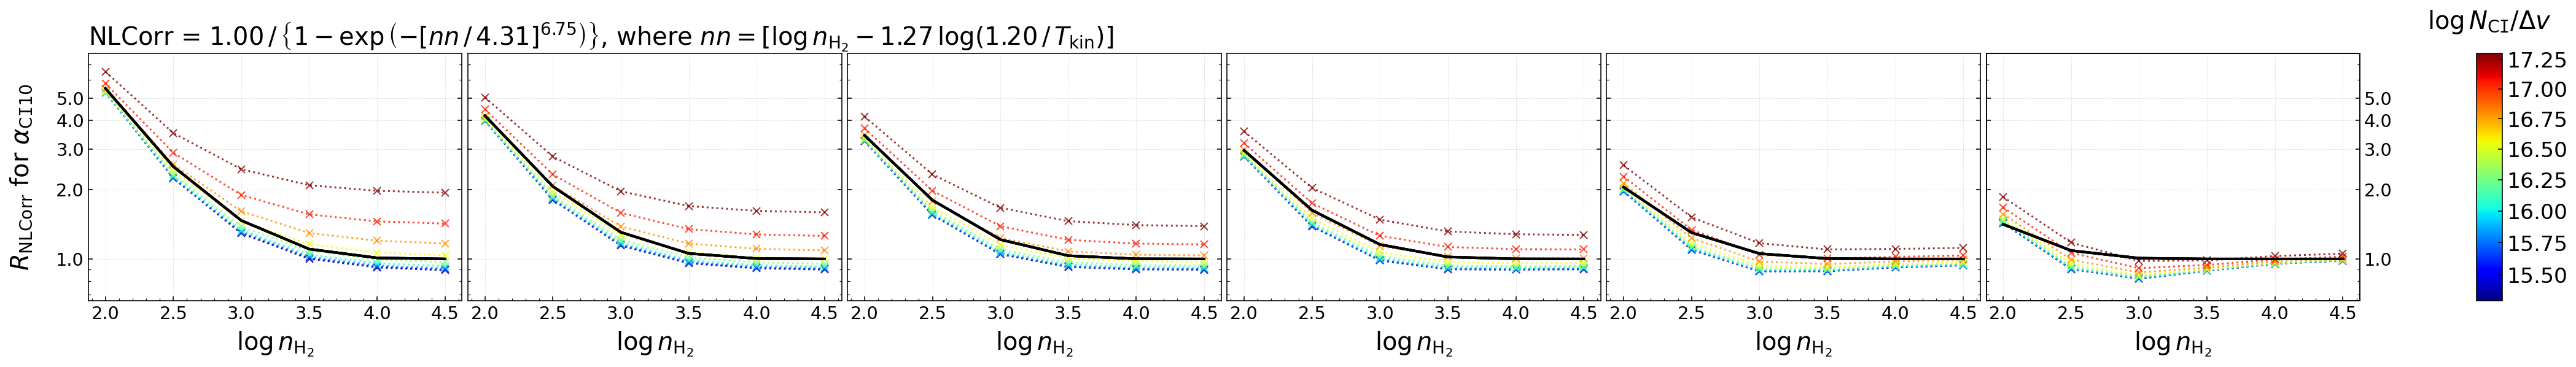

In [24]:
# Curve fit

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from IPython.display import display
from scipy.optimize import curve_fit

# Reload

%run calc_NonLTE_RADEX_plot_R_CI10CO21_correction_matrix.ipynb

if __name__ == '__main__' and '__file__' not in globals():

    select_X_CICO = 0.2

    out_fig_name = 'Plot_RADEX_alpha_CI10_varied_CO_abundance_selected_RNCINCO_' + \
                   ('%.1f'%(select_X_CICO)).replace('.','p')
    
# Redefine func

def func_NLCorr_hybrid(xxx, a, b, c, d, e):
    nn, mm, tt = xxx # log n_H2, log N_CI/d_V, T_kin
    gg = d * np.log10(e/tt)
    return a / ( 1.0 - np.exp( - ((nn - gg) / b)**(c) ) ) # * ( (10**mm / d)**(1.0 - np.exp(-(e/tt)**g)) )

def str_func_NLCorr_hybrid(a, b, c, d, e):
    str_func = '{:g} / ( 1.0 - np.exp( - ((np.log10(n_H2) - gg) / {:g})**({:g}) ) )'.format(a, b, c)
    str_func = str_func.replace('gg', '{:g} * np.log10({:g}/T_kin)'.format(d, e))
    return str_func

def latex_str_func_NLCorr_hybrid(a, b, c, d, e):
    latex_str = r'${:.2f} / \left\{{ 1 - \exp\left( - [nn / {:.2f}]^{{{:.2f}}} \right) \right\}}$'.format(a, b, c)
    latex_str += r', where $nn = [log_n_H2 - {:.2f} * \log ({:.2f}/T_kin)]$'.format(d, e)
    latex_str = latex_str.replace('N_CO_d_V', r'N_{\mathrm{CO}}/{\Delta v}')
    latex_str = latex_str.replace('log_n_H2', r'\log n_{\mathrm{H_2}}')
    latex_str = latex_str.replace('T_kin', r'T_{\mathrm{kin}}')
    latex_str = latex_str.replace('e+', 'e')
    latex_str = latex_str.replace('*', r'\,')
    latex_str = latex_str.replace('/', r'\,/\,')
    return latex_str

def fit_func_NLCorr_hybrid(xxx, y):
    popt, pcov = curve_fit(func_NLCorr_hybrid, xxx, y, p0=[10.0, 3.2, 3.2, 1.0, 75.])
    yfit = func_NLCorr_hybrid(xxx, *popt)
    return popt, yfit

def func_NLCorr(x, a, b, c):
    return a / ( 1.0 - np.exp( - (x / b)**(c) ) )

def str_func_NLCorr(a, b, c):
    str_func = '{:g} / ( 1.0 - np.exp( - (np.log10(n_H2) / {:g})**({:g}) ) )'.format(a, b, c)
    return str_func

def fit_func_NLCorr(x, y):
    popt, pcov = curve_fit(func_NLCorr, x, y, p0=[10.0, 3.2, 3.2])
    yfit = func_NLCorr(x, *popt)
    return popt, yfit

# Save NLCorr matrix to file and plot curve fit

if __name__ == '__main__' and '__file__' not in globals():
    
    out_NLCorr_matrix_file = 'out_NLCorr_matrix_alphaCI10.fits'
    save_NLCorr_matrix_to_file(
        x_array = xpos_array[0,:], 
        y_array = ypos_array[:,0], 
        z_array = np.array(list_of_T_kin), 
        data_array = fig3_array, 
        out_NLCorr_matrix_file = out_NLCorr_matrix_file,
        y_type = 'log10 N_CI/d_V', # for fits file CTYPE2
    )
    
    plot_curve_fit(
        x_array = xpos_array[0,:], 
        y_array = ypos_array[:,0], 
        z_array = np.array(list_of_T_kin), 
        data_array = fig3_array, 
        out_fig_name = out_fig_name, 
        y_type = 'log N_CI/d_V', # for printing
        ylabel = r'$R_{\mathrm{NLCorr}}$ for $\alpha_{\mathrm{C}{\tt{I}}10}$', 
        colorbar_title = r'$\log N_{\mathrm{C}{\tt{I}}}/{\Delta v}$', 
        do_curve_fit_levels = [0, 3],
        color_for_curve_fit_levels = {3: 'k'}, 
    )


axRight y[0,0] 15.301029995663981 y[-1,0] 17.30102999566398
axRight ylim 1.6014179100000001 160.141791
axRight ylim 0.2045046812778552 2.204504681277855 in log
axRight ylim [0.07950468 2.32950468]
axRight ylim [  1.20089402 213.55251048] in linear
axRight set_ylim [  1.20089402 213.55251048]
axRight get_ylim (1.200894017430284, 213.55251048351965)
Output to 'Plot_RADEX_alpha_CI10_varied_CO_abundance_selected_RNCINCO_0p2_R_NLCorr_residual.pdf'


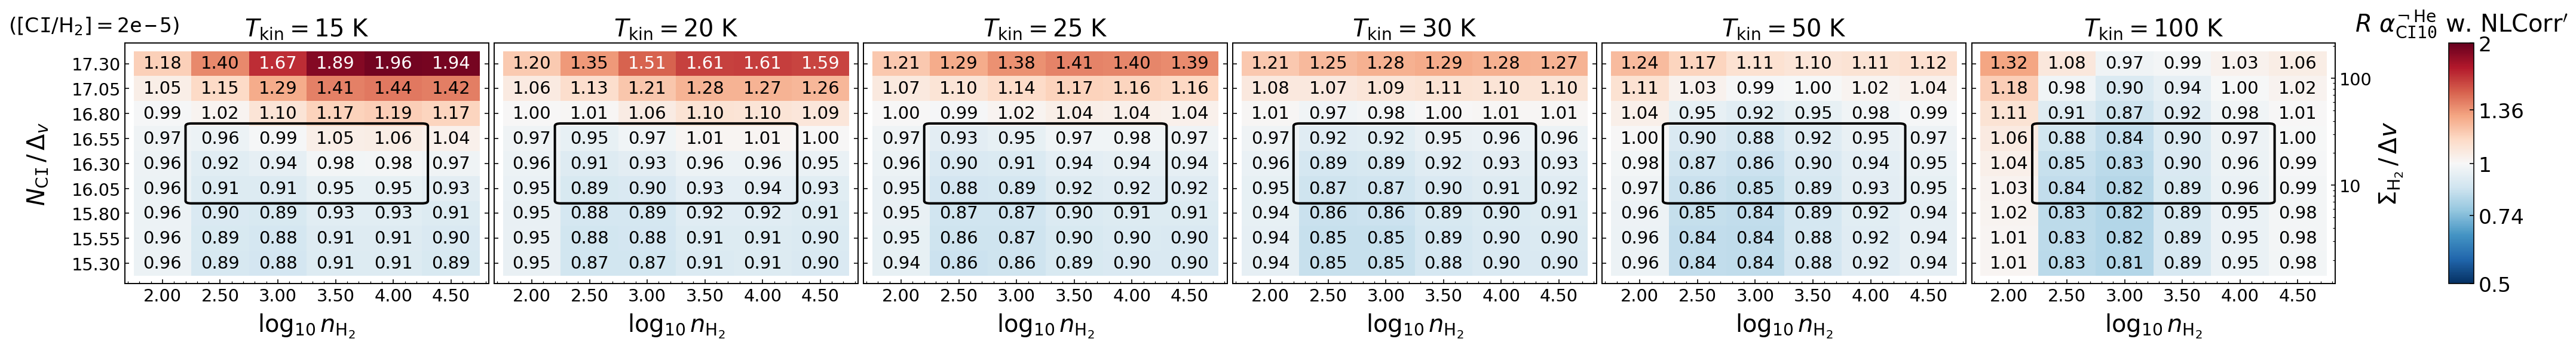

In [9]:
# Make fig4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

if __name__ == '__main__' and '__file__' not in globals():

    colorbar_title = r'$R \ \alpha_{\mathrm{C}\tt{I}10}^{\neg\,\mathrm{He}}$' + ' ' + \
                     r'w. $\mathrm{NLCorr}^{\prime}$'
    
    colorbar_ticks = [0.5, 0.74, 1.0, 1.36, 2.0]

    fig4 = plot_one_figure(
        xpos_array, 
        ypos_array, 
        fig4_array, 
        vmin = 0.5, 
        vmax = 2.0, 
        aspect = aspect, 
        panel_titles = panel_titles, 
        colorbar_title = colorbar_title, 
        colorbar_ticks = colorbar_ticks, 
        topleft_text = topleft_text, 
        ylabel = ylabel, 
        rightmost_yfunc = rightmost_yfunc, 
        highlight_boxes = highlight_boxes, 
        save_figure_file = out_fig_name + '_R_NLCorr_residual.pdf', 
    )